In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

from collections import deque

# Knapsack Problem

In [26]:
MAX_ITEM_WEIGHT = 10
MAX_ITEM_VALUE = 10

class Knapsack:
    def __init__(self, N, max_weight):
        self.items = []
        self.all_items = N
        self.max_weight = max_weight
        self.generate_knapsack(N)

    def generate_knapsack(self, N):
        for i in range(N):
            self.items.append(
                (random.randint(1, self.max_weight), 
                random.randint(1, MAX_ITEM_VALUE))
            )
    def calculate_value(self, items):
        weight = 0
        value = 0

        for i, is_taken in enumerate(items):
            if is_taken:
                weight += self.items[i][0]
                value += self.items[i][1]
        return value if weight <= self.max_weight else -1

    def size(self):
        return len(self.items)

In [102]:
W = 5
knapsack = Knapsack(3, W)
print(knapsack.items)

[(5, 7), (1, 7), (4, 10)]


In [103]:
import pennylane as qml
from pennylane.templates import ApproxTimeEvolution
from pennylane import numpy as np

In [104]:
def x(wire):
    return qml.Hamiltonian([0.5, -0.5], [qml.Identity(wire), qml.PauliZ(wire)])

In [140]:
def create_cost_hamiltonian(knapsack: Knapsack, gamma_A, gamma_B, time=1):
    hamiltonian = qml.Identity(0) #  remove

    xs = range(0, knapsack.all_items)
    ys = list(range(knapsack.all_items, knapsack.all_items + knapsack.max_weight))

    gamma_A = gamma_A + gamma_B * max([item[1] for item in knapsack.items]) + 0.1
    
    for y in ys:
        hamiltonian -= gamma_A * x(y)
    
    for y in range(1, knapsack.max_weight+1):
        hamiltonian += gamma_A * y**2 * x(ys[y-1])
    
    for _x in xs:
        hamiltonian += gamma_A * knapsack.items[_x][0]**2 * x(_x)
    
    for y1 in range(1, knapsack.max_weight+1):
        for y2 in range(y1 + 1, knapsack.max_weight+1):
            hamiltonian += gamma_A * 2 * y1 * y2 * (x(ys[y1-1]) @ x(ys[y2-1]))
    
    for _x1 in xs:
        for _x2 in range(_x1 + 1, knapsack.all_items):
            hamiltonian += gamma_A * knapsack.items[_x1][0]*knapsack.items[_x2][0] * (x(_x1) @ x(_x2))

    for y1 in range(1, knapsack.max_weight+1):
        for _x1 in xs:
            hamiltonian -= gamma_A * y1 * knapsack.items[_x1][0] * (x(ys[y1-1]) @ x(_x1))
        
    for _x in xs:
        hamiltonian -= gamma_B * knapsack.items[_x][1] * x(_x)
    ApproxTimeEvolution(hamiltonian, time, 1)

In [141]:
def create_mixing_hamitonian(wires, beta, time=1):
    hamiltonian = qml.Identity(0)
    for i in range(wires):
        hamiltonian += qml.Hamiltonian([beta], [qml.PauliX(i)])
    ApproxTimeEvolution(hamiltonian, time, 1)

In [142]:
def hadamard_layer(wires):
    for i in range(wires):
        qml.Hadamard(i)

In [143]:
n_wires = knapsack.all_items + knapsack.max_weight
dev = qml.device("default.qubit", wires=n_wires, shots=1)

In [144]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad=False)
pauli_z_4 = np.kron(pauli_z_2, pauli_z_2, requires_grad=False)

@qml.qnode(dev)
def circuit(gammas_A, gammas_B, betas, knapsack, n_layers=1):
    hadamard_layer(knapsack.all_items + knapsack.max_weight)
    for i in range(n_layers):
        create_cost_hamiltonian(knapsack, gammas_A[i], gammas_B[i])
        create_mixing_hamitonian(knapsack.all_items + knapsack.max_weight, betas[i])

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(knapsack.all_items + knapsack.max_weight)]

/tmp/ipykernel_21311/3182896877.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


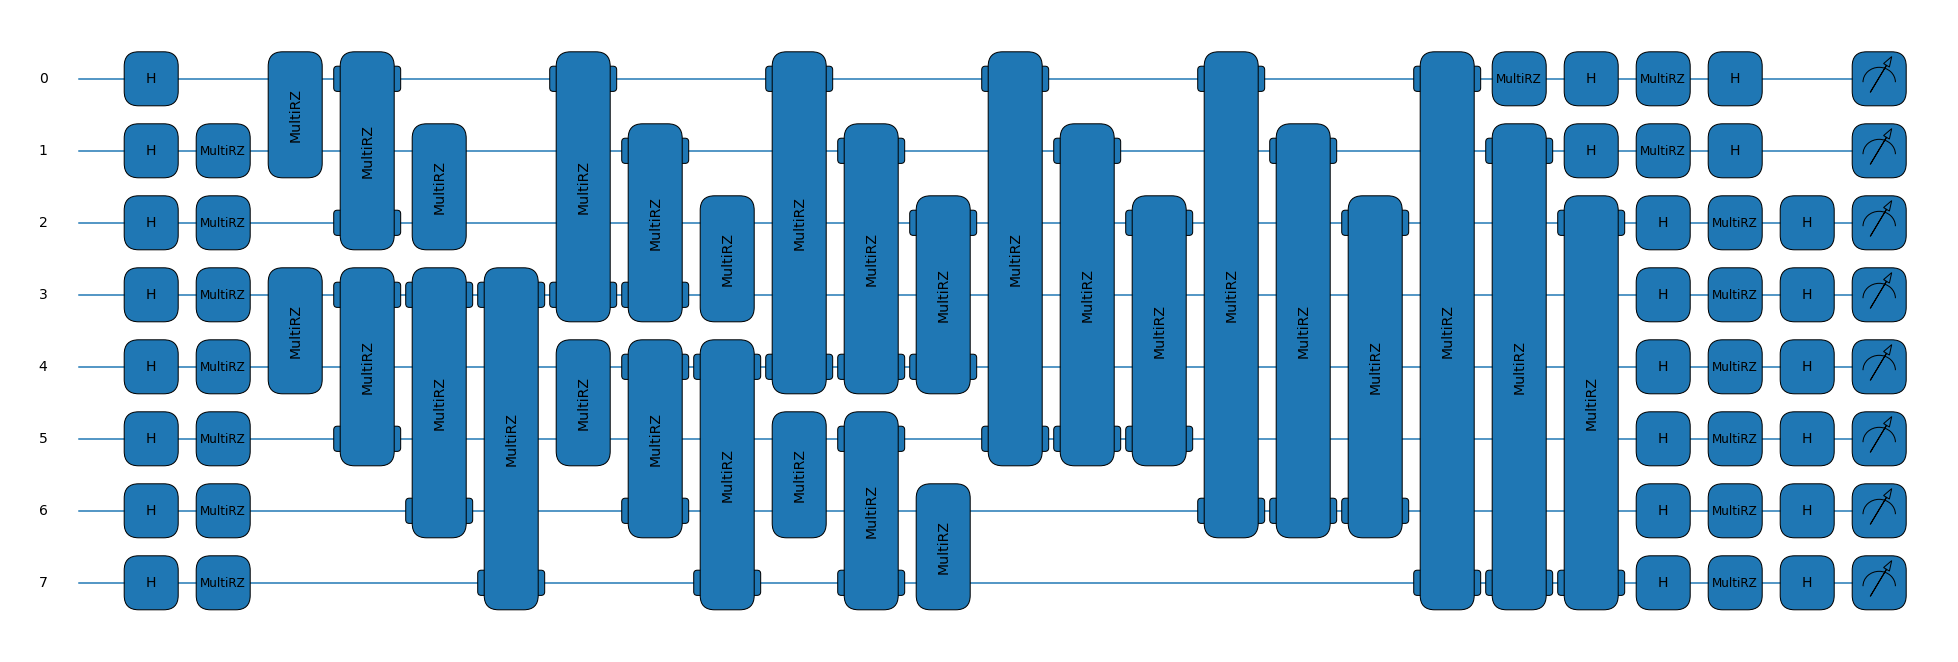

In [145]:
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")([0], [0], [0], knapsack)
fig.show()

In [146]:
def check_results(results, knapsack):
    sum = 0
    weight = 0
    for i, item in enumerate(knapsack.items):
        if results[i] == 1:
            sum += item[1]
            weight += item[0]
    if weight > knapsack.max_weight:
        return -100
    for i in range(knapsack.max_weight):
        if results[i + knapsack.all_items] == 1 and i+1 != weight:
            return -100

    return sum


In [147]:
check_results([0, 1, 1, 0, 0, 0, 0, 1], knapsack)

17

In [148]:
result = circuit([0, 0], [0, 0], [0, 0], knapsack)
print(result)
check_results(result, knapsack)

[-1. -1. -1.  1. -1. -1. -1. -1.]


-100

In [149]:
%load_ext autoreload
%autoreload 2
from CEM_optimizer_pennylane import CEMOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = ([0]*n_layers*2)

    # minimize the negative of the objective function
    def objective(params):
        gammas_A = params[:len(params)//2]
        gammas_B = params[len(params)//2:]
        betas = [1/2]*(len(params)//2)
        result = circuit(gammas_A, gammas_B, betas, knapsack, n_layers)

        return -check_results(result, knapsack)

    # initialize optimizer: Adagrad works well empirically
    opt = CEMOptimizer(init_params)

    # optimize parameters in objective
    params = init_params
    params = opt.step(objective)
    # steps = 1
    # for i in range(steps):
        
    #     if (i + 1) % 5 == 0:
    #         print(params)
    #         print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    # bit_strings = []
    # n_samples = 100
    # for i in range(0, n_samples):
    #     bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    # counts = np.bincount(np.array(bit_strings))
    # most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params))
    # print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params)


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
# bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=1)


p=1
Episode 5	Average Score: 78.60
[0.98917625 0.60446442] with reward: -7
Episode 10	Average Score: 89.30
[0.98917625 0.60446442] with reward: -7
Optimized (gamma, beta) vectors:
[0.98917625 0.60446442]


In [119]:
for i in range(1024):
    circuit_ = circuit([0.09558931], [0.4727249], knapsack, 1)
    print(f"Shot {i}: {circuit_} -> {check_results(circuit_, knapsack)}")

Shot 0: [ 1.  1.  1. -1.  1.  1. -1.  1.] -> -100
Shot 1: [ 1.  1.  1. -1. -1.  1.  1. -1.] -> -100
Shot 2: [ 1.  1.  1. -1. -1.  1.  1. -1.] -> -100
Shot 3: [ 1.  1. -1. -1.  1.  1. -1. -1.] -> -100
Shot 4: [ 1.  1.  1. -1. -1. -1.  1.  1.] -> -100
Shot 5: [ 1.  1.  1. -1. -1.  1. -1.  1.] -> -100
Shot 6: [ 1.  1.  1. -1. -1. -1.  1.  1.] -> -100
Shot 7: [-1.  1. -1.  1. -1. -1. -1.  1.] -> -10
Shot 8: [-1.  1. -1.  1. -1. -1. -1.  1.] -> -10
Shot 9: [ 1.  1.  1. -1. -1. -1.  1.  1.] -> -100
Shot 10: [ 1.  1.  1. -1. -1. -1. -1.  1.] -> -100
Shot 11: [-1.  1. -1. -1.  1. -1. -1. -1.] -> -10
Shot 12: [ 1.  1.  1. -1. -1. -1.  1.  1.] -> -100
Shot 13: [ 1. -1.  1.  1. -1. -1.  1.  1.] -> -100
Shot 14: [-1.  1. -1. -1. -1.  1.  1.  1.] -> -10
Shot 15: [-1. -1. -1. -1. -1. -1.  1. -1.] -> -10
Shot 16: [-1.  1.  1.  1. -1.  1. -1.  1.] -> -10
Shot 17: [ 1.  1.  1.  1.  1.  1.  1. -1.] -> -100
Shot 18: [-1.  1. -1. -1. -1. -1. -1.  1.] -> -10
Shot 19: [ 1.  1.  1.  1. -1. -1.  1.  1.] -> -1